# Pipeline
## File to demonstrate the general application of the method
A process model is used, e.g. graph G.
If this process model is already acyclic, one can continue with the generation of the UPPAAL model.
Otherwise, the model is unrolled.

The unrolled model is then converted to a UPPAAL model, used for model checking and simulations.

For an application-example, see the file "case_study.ipynb"

## Process Model
Exemplary process model from the paper

In [1]:
# User variables
SAVE_ELEMENTS = True # True if figures and models shall be saved

In [2]:
import networkx as nx
import copy
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

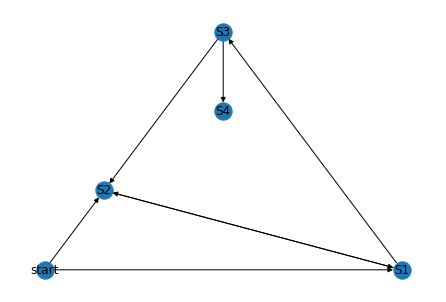

In [3]:
G=nx.DiGraph()

G.add_nodes_from(["start","S1","S2","S3","S4"])
G.add_edges_from([("start","S1"),("start","S2"),("S2","S1"),("S1", "S2"),("S1","S3"),("S3","S2"),("S3","S4")])
target = "S4"

pos = nx.planar_layout(G)
nx.draw(G, with_labels = True, pos = pos)

k = 1
start = "start"

## Unrolling
The cyclic journey game is transformed into an acyclic journey game by breadth-first search and loop counting

In [4]:
# Computes all possible shift of lists
def shifted_lists(l):
    shifted_lists = []
    for j in range(len(l)):
        list_constructed = copy.deepcopy(l[j:])
        list_constructed.extend(l[:j])
        list_constructed.append(list_constructed[0])
        shifted_lists.append(list_constructed)
    return shifted_lists

# checks if history hist contains circle c
def contains(hist, c):
    n = len(c)+1
    max_count = 0
    lists = shifted_lists(c)
    for helper_list in lists:
        count = 0
        for i in range(len(hist)-(n-1)):
            if hist[i:i+n] == helper_list:
                count += 1
        max_count = max(max_count, count)
    return max_count

# returns true if edge (e,v) is on c
def is_on(e,v,c):
    for i in range(len(c)-1):
        if c[i] == e and c[i+1] == v:
            return True
    if c[-1] == e and c[0] == v:
        return True


# Presented Unrolling algorithm, Algorithm 1 with online reducing
def unroll(G, start, target, k, debug = False):
    G_gen = nx.DiGraph()
    G_gen.add_node(start, hist = [str(start)])
    if 'controllable' in G.nodes[start]:
        G_gen.nodes[start]["controllable"] = G.nodes[start]["controllable"]

    cycles = list(nx.simple_cycles(G))

    queue = [start]
    # start bf-search
    while(queue):
        s = queue[0]
        queue.pop(0)
        s_original = str(s).split(".")[0]
        neighbours = list(G[s_original])
        for t in neighbours:
            t_original = t
            local_hist = copy.deepcopy(G_gen.nodes[s]["hist"])
            local_hist.append(str(t_original))
            is_on_cycle = False
            can_traverse = False
            path = []
            circle = []
            relevant_cycle = []
            for c in cycles:
                if is_on(s_original,t_original,c):
                    relevant_cycle.append(c)
                    
            all_smaller = True
            for c in relevant_cycle:
                if contains(local_hist,c) >= k:
                    all_smaller = False
            
            if not all_smaller:
                paths = list(nx.all_simple_paths(G, source=t, target=target))
                for p in paths:
                    merged_hist = copy.deepcopy(local_hist)
                    merged_hist.extend(p[1:]) # 1.st element already added
                    can_not_traverse = False
                    
                    #test if no loop larger than k with path
                    for c_loop in relevant_cycle:
                        if contains(merged_hist,c_loop) > k : # check that there is path without completing additional cycle
                            can_not_traverse = True
                    can_traverse = not can_not_traverse
            if all_smaller or can_traverse:               
                #every node not on cycle can be unqiue ("merge point" within unrolled graph)
                if relevant_cycle:
                    while t in G_gen.nodes:
                        if "." not in t:
                            t += ".1"
                        else:
                            t = t.split(".")[0]+"."+str(int(t.split(".")[-1])+1)
                # add node t only to graph if not already treated

                if t not in queue:
                    queue.append(t)
                    G_gen.add_node(t, hist = local_hist)
                assert(s in G_gen and t in G_gen)
                G_gen.add_edge(s,t)
                if('label' in G[s_original][t_original]):
                    G_gen[s][t]['label'] = G[s_original][t_original]['label']
                if('controllable' in G.nodes[t_original]):
                    G_gen.nodes[t]['controllable'] = G.nodes[t_original]['controllable']

    print("Graph was unrolled")
    return G_gen

Graph was unrolled


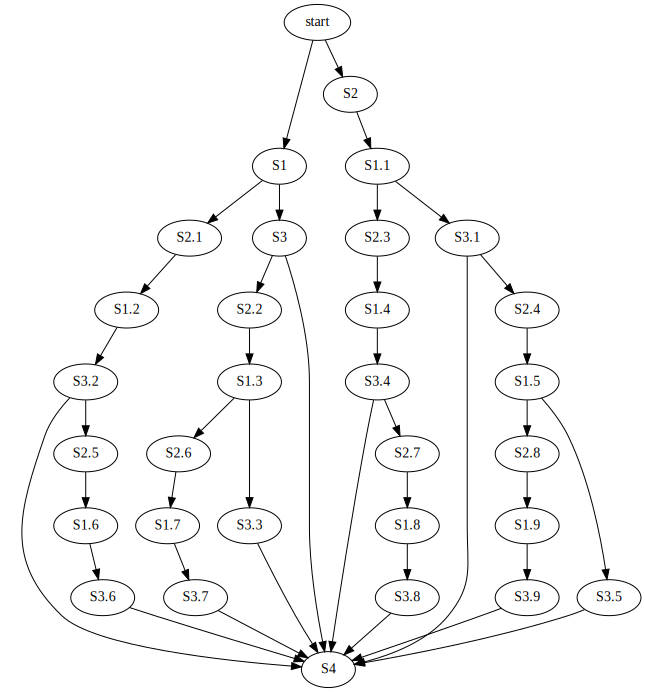

In [5]:
G_unroll = unroll(G, start,[target],1)
A = to_agraph(G_unroll)
A.layout('dot')
if SAVE_ELEMENTS:
    A.draw('unrolled.png')
A

## Mapping to UPPAAL
Afterwards is a corresponding UPPAAL model constructed.

In [6]:
# Method to produce unrolled graph
def to_uppaal(g):
    f = open("unrolled_graph.xml", "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot', args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location(f, "id"+str(i),pos[s][0],pos[s][1],s)
    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    for e in g.edges:
        print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]])
    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    print("All written to", f.name)

def print_location(f, location_id, x, y, name):
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y))+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    if "finPos" not in name and "finNeg" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge(f, s, t, pos_s, pos_t):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    
    f.write('<transition action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
    
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('steps += 1')
    f.write(',\n'+ 'x = 0')
    f.write('</label>')
    
    f.write('</transition>')

In [7]:
if SAVE_ELEMENTS:
    to_uppaal(G_unroll)

All written to unrolled_graph.xml


## Model Checking
The resulting UPPAAL model is then verified under several queries:
- Can the company guarantee that the user reaches the positive end state:
```
strategy goPos = control: A<> Journey.finPos
```
- Establish lower and upper bounds on the gas level within the journey:
```
Journey.finPos --> e > 0 under goPos
control: A[] gas > -41 under goPos
```
- Compute statistics for strategies:
```
E[t<=100; 500] (max: steps) under goPos
E[t<=100; 500] (min: gas) under goPos
E[t<=100; 500] (max: finalGas) under goPos
E[t<=100; 500] (min: finalGas) under goPos
```
- Refine the strategy to optimise among others number of steps in the journey:
```
strategy goPosFast = minE(steps) [t<= 100] : <> Journey.finPos under goPos
```
- Simulations to visualize energy states within the journey:
```
simulate 10 [t<=100]{Journey.finPos, gas} under goPos
```